In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import os
import _pickle as cPickle
from collections import defaultdict, OrderedDict

import numpy as np
import keras.backend as K

import kde
import simplebinmi

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
matplotlib.rc("savefig", dpi=300)
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

import utils
trn, tst = utils.get_pokeman()

FULL_MI = True

# Which measure to plot
infoplane_measure = 'upper'
#infoplane_measure = 'bin'

DO_SAVE        = True    # Whether to save plots or just show them
DO_LOWER       = False    # (infoplane_measure == 'lower')   # Whether to compute lower bounds also
DO_BINNED      = False    #(infoplane_measure == 'bin')     # Whether to compute MI estimates based on binning

MAX_EPOCHS = 25000      # Max number of epoch for which to compute mutual information measure # Anver changed from 10000

COLORBAR_MAX_EPOCHS = 25000

# Directories from which to load saved layer activity
# ARCH = '1024-20-20-20'
#ARCH = '20-20-20-20-20-20'
#ARCH = '32-28-24-20-16-12'
#ARCH = '32-28-24-20-16-12-8-8'
ARCH = '16-16-8'
DIR_TEMPLATE = '%%s_%s'%ARCH

# Functions to return upper and lower bounds on entropy of layer activity
# noise_variance = 1e-3                    # Added Gaussian noise variance
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, 1e-3),])
entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, 1e-3),])


# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 

if FULL_MI:
    full = utils.construct_full_dataset(trn,tst)
    y = full.y
    Y = full.Y

# Save indexes of tests data for each of the output classes
saved_labelixs = {}
for i in range(3):
    saved_labelixs[i] = y == i

labelprobs = np.mean(tst.Y, axis=0)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [2]:
PLOT_LAYERS    = None     # Which layers to plot.  If None, all saved layers are plotted 

# Data structure used to store results
measures = OrderedDict()
measures['tanh'] = {}      ## Anver changed from relu to tanh
# measures['tanh'] = {}

Compute MI measures
-----

In [3]:
for activation in measures.keys():
    cur_dir = 'rawdata/' + DIR_TEMPLATE % activation
    if not os.path.exists(cur_dir):
        print("Directory %s not found" % cur_dir)
        continue
        
    # Load files saved during each epoch, and compute MI measures of the activity in that epoch
    print('*** Doing %s ***' % cur_dir)
    for epochfile in sorted(os.listdir(cur_dir)):
        if not epochfile.startswith('epoch'):
            continue
            
        fname = cur_dir + "/" + epochfile
        with open(fname, 'rb') as f:
            d = cPickle.load(f)

        epoch = d['epoch']
        if epoch in measures[activation]: # Skip this epoch if its already been processed
            continue                      # this is a trick to allow us to rerun this cell multiple times)
            
        if epoch > MAX_EPOCHS:
            continue

        print("Doing", fname)
        
        num_layers = len(d['data']['activity_tst'])

        if PLOT_LAYERS is None:
            PLOT_LAYERS = []
            for lndx in range(num_layers):
                #if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
                PLOT_LAYERS.append(lndx)
                
        cepochdata = defaultdict(list)
        
        noise_variance = 1e-3
        max_activity = np.max(d['data']['activity_tst'][0])
        for lndx in range(num_layers):
            activity = d['data']['activity_tst'][lndx]
            
            ada_noise_variance = noise_variance*np.max(activity)

            # Compute marginal entropies
            h_upper = entropy_func_upper([activity, ada_noise_variance])[0]
            if DO_LOWER:
                h_lower = entropy_func_lower([activity, ada_noise_variance])[0]
                
            # Layer activity given input. This is simply the entropy of the Gaussian noise
            hM_given_X = kde.kde_condentropy(activity, ada_noise_variance)

            # Compute conditional entropies of layer activity given output
            hM_given_Y_upper=0.
            for i in range(3):
                hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:], ada_noise_variance])[0]
                hM_given_Y_upper += labelprobs[i] * hcond_upper
                
            if DO_LOWER:
                hM_given_Y_lower=0.
                for i in range(3):
                    hcond_lower = entropy_func_lower([activity[saved_labelixs[i],:], ada_noise_variance])[0]
                    hM_given_Y_lower += labelprobs[i] * hcond_lower
                    
                
            cepochdata['MI_XM_upper'].append( nats2bits * (h_upper) )
            cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
            cepochdata['H_M_upper'  ].append( nats2bits * h_upper )

            pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1])
            if DO_LOWER:  # Compute lower bounds
                cepochdata['MI_XM_lower'].append( nats2bits * (h_lower) )
                cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

            if DO_BINNED: # Compute binner estimates
                binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                cepochdata['MI_YM_bin'].append( nats2bits * binym )
                pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])
            
            print('- Layer %d %s' % (lndx, pstr) )

        measures[activation][epoch] = cepochdata
    

*** Doing rawdata/tanh_16-16-8 ***
Doing rawdata/tanh_16-16-8/epoch00000000
- Layer 0 upper: MI(X;M)=12.790, MI(Y;M)=0.003
- Layer 1 upper: MI(X;M)=12.731, MI(Y;M)=0.003
- Layer 2 upper: MI(X;M)=6.270, MI(Y;M)=0.001
- Layer 3 upper: MI(X;M)=2.194, MI(Y;M)=0.000
Doing rawdata/tanh_16-16-8/epoch00000001
- Layer 0 upper: MI(X;M)=12.790, MI(Y;M)=0.003
- Layer 1 upper: MI(X;M)=12.730, MI(Y;M)=0.003
- Layer 2 upper: MI(X;M)=6.271, MI(Y;M)=0.001
- Layer 3 upper: MI(X;M)=2.193, MI(Y;M)=0.000
Doing rawdata/tanh_16-16-8/epoch00000002
- Layer 0 upper: MI(X;M)=12.790, MI(Y;M)=0.003
- Layer 1 upper: MI(X;M)=12.729, MI(Y;M)=0.003
- Layer 2 upper: MI(X;M)=6.271, MI(Y;M)=0.001
- Layer 3 upper: MI(X;M)=2.193, MI(Y;M)=0.000
Doing rawdata/tanh_16-16-8/epoch00000003
- Layer 0 upper: MI(X;M)=12.790, MI(Y;M)=0.003
- Layer 1 upper: MI(X;M)=12.728, MI(Y;M)=0.003
- Layer 2 upper: MI(X;M)=6.273, MI(Y;M)=0.001
- Layer 3 upper: MI(X;M)=2.192, MI(Y;M)=0.000
Doing rawdata/tanh_16-16-8/epoch00000004
- Layer 0 upper:

- Layer 3 upper: MI(X;M)=3.285, MI(Y;M)=0.001
Doing rawdata/tanh_16-16-8/epoch00000110
- Layer 0 upper: MI(X;M)=12.983, MI(Y;M)=0.004
- Layer 1 upper: MI(X;M)=13.169, MI(Y;M)=0.004
- Layer 2 upper: MI(X;M)=7.633, MI(Y;M)=0.005
- Layer 3 upper: MI(X;M)=3.423, MI(Y;M)=0.002
Doing rawdata/tanh_16-16-8/epoch00000120
- Layer 0 upper: MI(X;M)=13.020, MI(Y;M)=0.004
- Layer 1 upper: MI(X;M)=13.257, MI(Y;M)=0.004
- Layer 2 upper: MI(X;M)=7.795, MI(Y;M)=0.006
- Layer 3 upper: MI(X;M)=3.563, MI(Y;M)=0.002
Doing rawdata/tanh_16-16-8/epoch00000130
- Layer 0 upper: MI(X;M)=13.060, MI(Y;M)=0.004
- Layer 1 upper: MI(X;M)=13.353, MI(Y;M)=0.005
- Layer 2 upper: MI(X;M)=7.963, MI(Y;M)=0.007
- Layer 3 upper: MI(X;M)=3.723, MI(Y;M)=0.002
Doing rawdata/tanh_16-16-8/epoch00000140
- Layer 0 upper: MI(X;M)=13.101, MI(Y;M)=0.004
- Layer 1 upper: MI(X;M)=13.453, MI(Y;M)=0.006
- Layer 2 upper: MI(X;M)=8.133, MI(Y;M)=0.009
- Layer 3 upper: MI(X;M)=3.883, MI(Y;M)=0.003
Doing rawdata/tanh_16-16-8/epoch00000150
- Lay

- Layer 3 upper: MI(X;M)=5.822, MI(Y;M)=0.022
Doing rawdata/tanh_16-16-8/epoch00003000
- Layer 0 upper: MI(X;M)=14.109, MI(Y;M)=0.012
- Layer 1 upper: MI(X;M)=15.533, MI(Y;M)=0.035
- Layer 2 upper: MI(X;M)=10.450, MI(Y;M)=0.049
- Layer 3 upper: MI(X;M)=5.790, MI(Y;M)=0.021
Doing rawdata/tanh_16-16-8/epoch00003100
- Layer 0 upper: MI(X;M)=14.118, MI(Y;M)=0.013
- Layer 1 upper: MI(X;M)=15.538, MI(Y;M)=0.036
- Layer 2 upper: MI(X;M)=10.444, MI(Y;M)=0.049
- Layer 3 upper: MI(X;M)=5.777, MI(Y;M)=0.021
Doing rawdata/tanh_16-16-8/epoch00003200
- Layer 0 upper: MI(X;M)=14.127, MI(Y;M)=0.013
- Layer 1 upper: MI(X;M)=15.556, MI(Y;M)=0.036
- Layer 2 upper: MI(X;M)=10.423, MI(Y;M)=0.048
- Layer 3 upper: MI(X;M)=5.817, MI(Y;M)=0.023
Doing rawdata/tanh_16-16-8/epoch00003300
- Layer 0 upper: MI(X;M)=14.136, MI(Y;M)=0.013
- Layer 1 upper: MI(X;M)=15.563, MI(Y;M)=0.036
- Layer 2 upper: MI(X;M)=10.406, MI(Y;M)=0.048
- Layer 3 upper: MI(X;M)=5.809, MI(Y;M)=0.023
Doing rawdata/tanh_16-16-8/epoch00003400
-

- Layer 2 upper: MI(X;M)=10.613, MI(Y;M)=0.055
- Layer 3 upper: MI(X;M)=5.512, MI(Y;M)=0.019
Doing rawdata/tanh_16-16-8/epoch00006700
- Layer 0 upper: MI(X;M)=14.414, MI(Y;M)=0.020
- Layer 1 upper: MI(X;M)=15.881, MI(Y;M)=0.044
- Layer 2 upper: MI(X;M)=10.628, MI(Y;M)=0.055
- Layer 3 upper: MI(X;M)=5.527, MI(Y;M)=0.019
Doing rawdata/tanh_16-16-8/epoch00006800
- Layer 0 upper: MI(X;M)=14.424, MI(Y;M)=0.020
- Layer 1 upper: MI(X;M)=15.891, MI(Y;M)=0.045
- Layer 2 upper: MI(X;M)=10.662, MI(Y;M)=0.057
- Layer 3 upper: MI(X;M)=5.497, MI(Y;M)=0.018
Doing rawdata/tanh_16-16-8/epoch00006900
- Layer 0 upper: MI(X;M)=14.432, MI(Y;M)=0.020
- Layer 1 upper: MI(X;M)=15.904, MI(Y;M)=0.045
- Layer 2 upper: MI(X;M)=10.671, MI(Y;M)=0.057
- Layer 3 upper: MI(X;M)=5.525, MI(Y;M)=0.019
Doing rawdata/tanh_16-16-8/epoch00007000
- Layer 0 upper: MI(X;M)=14.442, MI(Y;M)=0.020
- Layer 1 upper: MI(X;M)=15.913, MI(Y;M)=0.046
- Layer 2 upper: MI(X;M)=10.705, MI(Y;M)=0.059
- Layer 3 upper: MI(X;M)=5.524, MI(Y;M)=0

- Layer 2 upper: MI(X;M)=11.429, MI(Y;M)=0.096
- Layer 3 upper: MI(X;M)=6.025, MI(Y;M)=0.036
Doing rawdata/tanh_16-16-8/epoch00010300
- Layer 0 upper: MI(X;M)=14.763, MI(Y;M)=0.026
- Layer 1 upper: MI(X;M)=16.439, MI(Y;M)=0.062
- Layer 2 upper: MI(X;M)=11.435, MI(Y;M)=0.097
- Layer 3 upper: MI(X;M)=6.017, MI(Y;M)=0.038
Doing rawdata/tanh_16-16-8/epoch00010400
- Layer 0 upper: MI(X;M)=14.774, MI(Y;M)=0.026
- Layer 1 upper: MI(X;M)=16.464, MI(Y;M)=0.063
- Layer 2 upper: MI(X;M)=11.498, MI(Y;M)=0.100
- Layer 3 upper: MI(X;M)=6.113, MI(Y;M)=0.036
Doing rawdata/tanh_16-16-8/epoch00010500
- Layer 0 upper: MI(X;M)=14.786, MI(Y;M)=0.026
- Layer 1 upper: MI(X;M)=16.490, MI(Y;M)=0.064
- Layer 2 upper: MI(X;M)=11.519, MI(Y;M)=0.101
- Layer 3 upper: MI(X;M)=6.156, MI(Y;M)=0.035
Doing rawdata/tanh_16-16-8/epoch00010600
- Layer 0 upper: MI(X;M)=14.798, MI(Y;M)=0.027
- Layer 1 upper: MI(X;M)=16.507, MI(Y;M)=0.065
- Layer 2 upper: MI(X;M)=11.531, MI(Y;M)=0.104
- Layer 3 upper: MI(X;M)=6.075, MI(Y;M)=0

- Layer 3 upper: MI(X;M)=6.633, MI(Y;M)=0.055
Doing rawdata/tanh_16-16-8/epoch00014000
- Layer 0 upper: MI(X;M)=15.306, MI(Y;M)=0.037
- Layer 1 upper: MI(X;M)=17.548, MI(Y;M)=0.129
- Layer 2 upper: MI(X;M)=11.677, MI(Y;M)=0.146
- Layer 3 upper: MI(X;M)=6.605, MI(Y;M)=0.056
Doing rawdata/tanh_16-16-8/epoch00014100
- Layer 0 upper: MI(X;M)=15.314, MI(Y;M)=0.037
- Layer 1 upper: MI(X;M)=17.559, MI(Y;M)=0.130
- Layer 2 upper: MI(X;M)=11.693, MI(Y;M)=0.147
- Layer 3 upper: MI(X;M)=6.607, MI(Y;M)=0.054
Doing rawdata/tanh_16-16-8/epoch00014200
- Layer 0 upper: MI(X;M)=15.323, MI(Y;M)=0.037
- Layer 1 upper: MI(X;M)=17.576, MI(Y;M)=0.131
- Layer 2 upper: MI(X;M)=11.743, MI(Y;M)=0.152
- Layer 3 upper: MI(X;M)=6.604, MI(Y;M)=0.057
Doing rawdata/tanh_16-16-8/epoch00014300
- Layer 0 upper: MI(X;M)=15.333, MI(Y;M)=0.037
- Layer 1 upper: MI(X;M)=17.592, MI(Y;M)=0.132
- Layer 2 upper: MI(X;M)=11.803, MI(Y;M)=0.157
- Layer 3 upper: MI(X;M)=6.641, MI(Y;M)=0.057
Doing rawdata/tanh_16-16-8/epoch00014400
-

- Layer 3 upper: MI(X;M)=6.783, MI(Y;M)=0.063
Doing rawdata/tanh_16-16-8/epoch00017700
- Layer 0 upper: MI(X;M)=15.608, MI(Y;M)=0.043
- Layer 1 upper: MI(X;M)=17.932, MI(Y;M)=0.162
- Layer 2 upper: MI(X;M)=12.060, MI(Y;M)=0.167
- Layer 3 upper: MI(X;M)=7.045, MI(Y;M)=0.060
Doing rawdata/tanh_16-16-8/epoch00017800
- Layer 0 upper: MI(X;M)=15.616, MI(Y;M)=0.043
- Layer 1 upper: MI(X;M)=17.950, MI(Y;M)=0.165
- Layer 2 upper: MI(X;M)=11.921, MI(Y;M)=0.164
- Layer 3 upper: MI(X;M)=6.749, MI(Y;M)=0.062
Doing rawdata/tanh_16-16-8/epoch00017900
- Layer 0 upper: MI(X;M)=15.623, MI(Y;M)=0.043
- Layer 1 upper: MI(X;M)=17.955, MI(Y;M)=0.165
- Layer 2 upper: MI(X;M)=11.984, MI(Y;M)=0.166
- Layer 3 upper: MI(X;M)=6.895, MI(Y;M)=0.066
Doing rawdata/tanh_16-16-8/epoch00018000
- Layer 0 upper: MI(X;M)=15.631, MI(Y;M)=0.044
- Layer 1 upper: MI(X;M)=17.969, MI(Y;M)=0.167
- Layer 2 upper: MI(X;M)=12.034, MI(Y;M)=0.173
- Layer 3 upper: MI(X;M)=6.958, MI(Y;M)=0.059
Doing rawdata/tanh_16-16-8/epoch00018100
-

Doing rawdata/tanh_16-16-8/epoch00021400
- Layer 0 upper: MI(X;M)=15.844, MI(Y;M)=0.048
- Layer 1 upper: MI(X;M)=18.239, MI(Y;M)=0.196
- Layer 2 upper: MI(X;M)=11.923, MI(Y;M)=0.187
- Layer 3 upper: MI(X;M)=6.878, MI(Y;M)=0.064
Doing rawdata/tanh_16-16-8/epoch00021500
- Layer 0 upper: MI(X;M)=15.848, MI(Y;M)=0.048
- Layer 1 upper: MI(X;M)=18.232, MI(Y;M)=0.195
- Layer 2 upper: MI(X;M)=11.844, MI(Y;M)=0.178
- Layer 3 upper: MI(X;M)=6.850, MI(Y;M)=0.067
Doing rawdata/tanh_16-16-8/epoch00021600
- Layer 0 upper: MI(X;M)=15.854, MI(Y;M)=0.049
- Layer 1 upper: MI(X;M)=18.253, MI(Y;M)=0.198
- Layer 2 upper: MI(X;M)=11.688, MI(Y;M)=0.176
- Layer 3 upper: MI(X;M)=6.641, MI(Y;M)=0.057
Doing rawdata/tanh_16-16-8/epoch00021700
- Layer 0 upper: MI(X;M)=15.859, MI(Y;M)=0.049
- Layer 1 upper: MI(X;M)=18.257, MI(Y;M)=0.199
- Layer 2 upper: MI(X;M)=11.673, MI(Y;M)=0.175
- Layer 3 upper: MI(X;M)=6.650, MI(Y;M)=0.059
Doing rawdata/tanh_16-16-8/epoch00021800
- Layer 0 upper: MI(X;M)=15.863, MI(Y;M)=0.049


Plot Infoplane Visualization
----

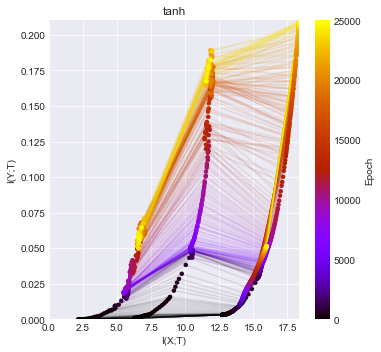

In [4]:
max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

fig=plt.figure(figsize=(10,5))    ## Anver changed from (10,5)
for actndx, (activation, vals) in enumerate(measures.items()):
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
    plt.subplot(1,2,actndx+1)  
    
    ylims = np.zeros((len(epochs),1))
    xlims = np.zeros((len(epochs),1))
    i = -1
    for epoch in epochs:
        i += 1
        c = sm.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[PLOT_LAYERS]

        plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=20, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)
        
        ylims[i] =  np.max(ymvals)
        xlims[i] =  np.max(xmvals)

    plt.ylim([0, np.max(ylims)])
    plt.xlim([0, np.max(xlims)])
    plt.xlabel('I(X;T)')
    plt.ylabel('I(Y;T)')
    plt.title(activation)
    
plt.colorbar(sm, label='Epoch')
plt.tight_layout()

if DO_SAVE:
    plt.savefig(DIR_TEMPLATE % ('infoplane_'+activation+ARCH),bbox_inches='tight')